# WeRateDogs: Data Wrangling

## Introduction

WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. The goal of this project is to wrangle WeRateDogs Twitter data to create interesting and trustworthy analyses and visualizations.

In [643]:
#import libraries necessary for this project
import pandas as pd
import numpy as np
import requests
import tweepy
import json
import io
import time
import re
import matplotlib.pyplot as plt
import scipy.stats as stats
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline  

## Gather

For this project, three pieces of data are required:
* The WeRateDogs Twitter archive, already availabe and stored locally
* The tweet image predictions, i.e., what breed of dog (or other object, animal, etc.) is present in each tweet according to a neural network.
* Each tweet's retweet count and favorite ("like") count. These can be acquired by querying the Twitter API. in your project submission.

In [551]:
# Load csv with WeRateDogs Twitter archive
archive = pd.read_csv('twitter-archive-enhanced.csv')
# Check if csv is loaded correctly
archive.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
248,845397057150107648,NaN,NaN,2017-03-24 22:08:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Mimosa. She's an emotional suppor...,NaN,NaN,NaN,"https://www.gofundme.com/help-save-a-pup,https...",13,10,Mimosa,doggo,None,None,None
693,786963064373534720,NaN,NaN,2016-10-14 16:13:10 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Rory. He's got an interview in a few m...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/786963064...,12,10,Rory,None,None,None,None
566,802247111496568832,NaN,NaN,2016-11-25 20:26:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Everybody drop what you're doin...,7.790561e+17,4.196984e+09,2016-09-22 20:33:42 +0000,https://twitter.com/dog_rates/status/779056095...,13,10,None,None,None,None,None
1263,710117014656950272,NaN,NaN,2016-03-16 14:54:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This pupper got her hair chalked for her birth...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/710117014...,11,10,None,None,None,pupper,None
543,805958939288408065,NaN,NaN,2016-12-06 02:15:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Penny. She fought a bee...,7.827226e+17,4.196984e+09,2016-10-02 23:23:04 +0000,https://twitter.com/dog_rates/status/782722598...,10,10,Penny,None,None,None,None


In [667]:
# Load tsv with tweet image predictions using the Requests library
r = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')
images = pd.read_csv(io.StringIO(r.text), sep = '\t')
# Info from: https://stackoverflow.com/questions/39213597/convert-text-data-from-requests-object-to-dataframe-with-pandas

# Store images dataframe
images.to_csv('image_predictions.csv', encoding='utf-8', index=False)

In [553]:
# Check if tsv is loaded correctly
images.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [554]:
# Gather retweets and favorites for every tweet in the WeRateDogs twitter archive file
# Create API object

consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit = True, wait_on_rate_limit_notify = True)

In [555]:
# Create test code for just one tweet
# Attributes that need to be grabbed according to Twitter dictionary: id, retweet_count, favorite_count

test_list = []
test_tweet = api.get_status('699446877801091073', tweet_mode='extended')
test_tweet = test_tweet._json


retweets = test_tweet['retweet_count']
favorites = test_tweet['favorite_count']
# quotes = test_tweet['quote_count']
# replies = test_tweet['reply_count']
# while testing, it appears that these two attributes are only available for users of the premium twitter API
        
# Append to list of dictionaries
test_list.append({'id': '699446877801091073', 'retweet_count': retweets, 'favorites_count': favorites})

print(test_list)

[{'id': '699446877801091073', 'retweet_count': 2844, 'favorites_count': 6331}]


In [556]:
# Use code from the cell above to query the Twitter API
tweet_list = []
start = time.time()

for tweet_id in archive['tweet_id']:
    
    try:
        tweet = api.get_status(tweet_id, tweet_mode='extended')
        tweet = tweet._json
        retweets = tweet['retweet_count']
        favorites = tweet['favorite_count']
        
        # Append to list of dictionaries
        tweet_list.append({'tweet_id': tweet_id, 'retweet_count': retweets,
                        'favorites_count': favorites})
        
    except Exception as e:
        print(tweet_id, e)
    
end = time.time()
print(end - start)

888202515573088257 [{'code': 144, 'message': 'No status found with that ID.'}]
873697596434513921 [{'code': 144, 'message': 'No status found with that ID.'}]
869988702071779329 [{'code': 144, 'message': 'No status found with that ID.'}]
866816280283807744 [{'code': 144, 'message': 'No status found with that ID.'}]
861769973181624320 [{'code': 144, 'message': 'No status found with that ID.'}]
845459076796616705 [{'code': 144, 'message': 'No status found with that ID.'}]
842892208864923648 [{'code': 144, 'message': 'No status found with that ID.'}]
837012587749474308 [{'code': 144, 'message': 'No status found with that ID.'}]
827228250799742977 [{'code': 144, 'message': 'No status found with that ID.'}]
802247111496568832 [{'code': 144, 'message': 'No status found with that ID.'}]
775096608509886464 [{'code': 144, 'message': 'No status found with that ID.'}]


Rate limit reached. Sleeping for: 616


754011816964026368 [{'code': 144, 'message': 'No status found with that ID.'}]


Rate limit reached. Sleeping for: 624


1980.0293991565704


In [557]:
# Write to JSON
with open('tweet_json.txt', 'w') as outfile:
    json.dump(tweet_list, outfile)

In [558]:
# Create dataframe
rtfav = pd.read_json('tweet_json.txt')
# Change order of columns
rtfav = rtfav.reindex(['tweet_id','retweet_count', 'favorites_count'], axis = 1)
# Check if the dataframe is loaded correctly
rtfav.head()

,tweet_id,retweet_count,favorites_count
0,892420643555336193,8540,38627
1,892177421306343426,6284,33110
2,891815181378084864,4161,24925
3,891689557279858688,8671,42023
4,891327558926688256,9423,40173


# Assess

First the data will be assessed visually and programmatically for quality and tidiness issues. Two quality issues were already reported: the tweets dataframe should only contain original tweets (no retweets) and all tweets should contain an image. 

The issues found during visual and programmatic assessment will be listed in the code cells below and in a summary at the end of this chapter.

## Visual assessment

In [559]:
archive
# The rating_denominator is not always 10, see for example id 2335/666287406224695296
# There are missing values for the dog names, for example "None" in row 5
# There are dog names that are probably wrong, like "such" at row 22, "quite" at 2326, "a" at 2327 and "an" at 2328
# The columns for dog stages seem to contain only value "None"
# Tidiness: each dog stage has its own column (rule: every variable -in this case: dog stage- forms a column)
# Tidiness: this table holds data on tweets as well as on dogs (rule: each type of observational unit forms a table)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [560]:
images
# Images cannot be used if p1_dog is False
# If p1 cannot be used we can decide to use p2 or p3 but it seems the confidence level for he algorithm is very low
# The dog breed names sometimes start with a capital, and are lowercase only other times
# The images table is shorter than the archive table (images has 2075 rows, archive has 2356 rows)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [561]:
rtfav
# Visually this table looks about right

,tweet_id,retweet_count,favorites_count
0,892420643555336193,8540,38627
1,892177421306343426,6284,33110
2,891815181378084864,4161,24925
3,891689557279858688,8671,42023
4,891327558926688256,9423,40173
5,891087950875897856,3118,20138
6,890971913173991426,2076,11808
7,890729181411237888,18930,65263
8,890609185150312448,4276,27684
9,890240255349198849,7434,31823


## Programmatic assessment

In [562]:
# Inspect the data types and the number of missing values
archive.info()
# Timestamp is a string which makes it difficult to use this variable for analysis
# There are 181 non-missing values for retweeted_status_id, these are probably the retweets
# There are missing values for the expanded url

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [563]:
# Check how many retweets are present in the dataframe
len(archive[archive['text'].str.startswith("RT")])

183

In [564]:
# Check if there are duplicate rows 
print(len(archive[archive['tweet_id'].duplicated()]))
print(len(archive[archive['text'].duplicated()]))
# There are no duplicated tweet_id's so we can assume that there is no duplicated content that has to be removed
# Furthermore, there are no two tweets with the same text

0
0


In [565]:
# There are only two columns in archive for which it makes sense to run descriptive statistics
print(archive['rating_numerator'].describe())
print(archive['rating_denominator'].describe())
# Rating_denominator should be 10 but has a max of 170
# Rating_numerator has a max of 1776

count    2356.000000
mean       13.126486
std        45.876648
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max      1776.000000
Name: rating_numerator, dtype: float64
count    2356.000000
mean       10.455433
std         6.745237
min         0.000000
25%        10.000000
50%        10.000000
75%        10.000000
max       170.000000
Name: rating_denominator, dtype: float64


In [566]:
# Check how many rating_denominator are not 10
archive['rating_denominator'].value_counts()
# Although the rating denominator should be 10, there are 23 tweets with a denominator higher or lower than 10
# Check the contents of the tweets that have a rating denominator other than 10
archive['text'][archive.rating_denominator != 10]
# Apparently, the second number in a string of two numbers is used as a denominator. Sometimes this is not the rating
# however, but for example a date. Furthermore, higher denominators occur when more dogs are present in the picture.

313     @jonnysun @Lin_Manuel ok jomny I know you're e...
342              @docmisterio account started on 11/15/15
433     The floofs have been released I repeat the flo...
516     Meet Sam. She smiles 24/7 &amp; secretly aspir...
784     RT @dog_rates: After so many requests, this is...
902     Why does this never happen at my front door......
1068    After so many requests, this is Bretagne. She ...
1120    Say hello to this unbelievably well behaved sq...
1165    Happy 4/20 from the squad! 13/10 for all https...
1202    This is Bluebert. He just saw that both #Final...
1228    Happy Saturday here's 9 puppers on a bench. 99...
1254    Here's a brigade of puppers. All look very pre...
1274    From left to right:\nCletus, Jerome, Alejandro...
1351    Here is a whole flock of puppers.  60/50 I'll ...
1433    Happy Wednesday here's a bucket of pups. 44/40...
1598    Yes I do realize a rating of 4/20 would've bee...
1634    Two sneaky puppers were not initially seen, mo...
1635    Someon

In [567]:
# Check the distribution of rating_numerators
print(archive['rating_numerator'].value_counts())
# Check the outlier numerator of 1776
archive['text'][archive.rating_numerator == 1776]
print(archive['text'][979])
# The rating numerator of 1776 refers to the year of the Declaration of Independence

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64
This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh


In [568]:
# Display all names of dogs
with pd.option_context('display.max_rows', 999):
    print(archive['name'].value_counts())
# The number of missing values is fairly high: 745. Not all tweet text contain a dog name though.
# There are strange dog names: 55 times "a", 8 times "the", 7 times "an", 5 times "very", 4 times "just", 
# 4 times "one", 4 times "quite" etc

None              745
a                  55
Charlie            12
Oliver             11
Cooper             11
Lucy               11
Penny              10
Lola               10
Tucker             10
Winston             9
Bo                  9
the                 8
Sadie               8
Bailey              7
Buddy               7
Daisy               7
Toby                7
an                  7
Jack                6
Bella               6
Milo                6
Jax                 6
Dave                6
Koda                6
Stanley             6
Scout               6
Leo                 6
Rusty               6
Oscar               6
Chester             5
Alfie               5
very                5
George              5
Larry               5
Sammy               5
Phil                5
Sunny               5
Louis               5
Bentley             5
Finn                5
Oakley              5
Gus                 5
Reggie              4
Clark               4
Carl                4
Sophie    

In [569]:
# Faulty dog names (None excluded) seem to start with a lower case letter, we can use this to generate a
# list of strange dog names

lower_case_list = []

for name in archive['name']:
    if name[0].islower():
        lower_case_list.append(name)

# Print all unique values in the list
print(set(lower_case_list))
# Print number of tweets in archive that have one of these strange names
print(len(lower_case_list))

{'infuriating', 'incredibly', 'light', 'unacceptable', 'officially', 'this', 'mad', 'my', 'not', 'by', 'all', 'getting', 'actually', 'one', 'such', 'just', 'space', 'his', 'life', 'an', 'very', 'the', 'old', 'quite', 'a'}
109


In [570]:
# Check how many of the tweet texts contain image urls
# First verify what an image url looks like by displaying some random text cells
print(archive['text'][5])
print(archive['text'][100])
print(archive['text'][200])
# Conclusion: image urls contain the following string "https://t.co/"

Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh
Here are my favorite #dogsatpollingstations 
Most voted for a more consistent walking schedule and to increase daily pats tenfold. All 13/10 https://t.co/17FVMl4VZ5
At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk


In [571]:
# Check how many of the tweet texts contain image urls
print(len(archive[archive['text'].str.contains("https://") == False]))
print(len(archive[archive['text'].str.contains("https://t.co") == False]))
# Apparently, there are 33 tweets that have a url in them, but not starting with https://t.co.

91
124


In [572]:
urls = archive['text'][(archive.text.str.contains("https://") == True) & (archive['text'].str.contains("https://t.co") == False)]
print(urls)
# Tweets with a url not starting with t.co are all retweets. Retweets will be removed later so we can let this go.

68      RT @dog_rates: This is Emmy. She was adopted t...
91      RT @dog_rates: This is Coco. At first I though...
124     RT @dog_rates: Say hello to Cooper. His expres...
146     RT @dog_rates: Say hello to Quinn. She's quite...
159     RT @dog_rates: Meet Lorenzo. He's an avid nift...
165     RT @dog_rates: Ohboyohboyohboyohboyohboyohboyo...
204     RT @dog_rates: I usually only share these on F...
230     RT @dog_rates: This is Charlie. He fell asleep...
247     RT @dog_rates: Here's a heartwarming scene of ...
250     RT @dog_rates: This is Bungalo. She uses that ...
273     RT @dog_rates: This is Pipsy. He is a fluffbal...
309     RT @dog_rates: Meet Lola. Her hobbies include ...
382     RT @dog_rates: This is Phil. He's an important...
434     RT @dog_rates: We are proud to support @LoveYo...
438     RT @dog_rates: This is Oliver. He has dreams o...
475     RT @dog_rates: Meet Jack. He's one of the rare...
506     RT @dog_rates: Meet Sammy. At first I was like...
538     RT @do

In [573]:
# View number of times a value for dog stage is present
print(archive['doggo'].value_counts())
print(archive['floofer'].value_counts())
print(archive['pupper'].value_counts())
print(archive['puppo'].value_counts())
# Conclusion: assuming a dog can only have one stage at a time, dog stage is only available for in total 394 tweets

None     2259
doggo      97
Name: doggo, dtype: int64
None       2346
floofer      10
Name: floofer, dtype: int64
None      2099
pupper     257
Name: pupper, dtype: int64
None     2326
puppo      30
Name: puppo, dtype: int64


In [574]:
# Inspect the data types and the number of missing values
images.info()
# There are no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [575]:
# Run descriptive statistics for the numeric values
images.describe()
# The mean confidence levels for p2 and p3 are only 13% and 6% respectively

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [576]:
# Check for duplicate rows
len(images[images['tweet_id'].duplicated()])

0

In [577]:
# Check the number of times where an image is not a dog
len(images[images.p1_dog == False])

543

In [578]:
# Inspect the data types and the number of missing values
rtfav.info()
# The table with retweet_count and favorites_count has 14 missing rows compared to the archive table

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2344 entries, 0 to 2343
Data columns (total 3 columns):
tweet_id           2344 non-null int64
retweet_count      2344 non-null int64
favorites_count    2344 non-null int64
dtypes: int64(3)
memory usage: 73.2 KB


In [579]:
# Run descriptive statistics for the numeric values
rtfav.describe()

,tweet_id,retweet_count,favorites_count
count,2.344000e+03,2344.000000,2344.000000
mean,7.422890e+17,3007.308447,8031.723549
std,6.835057e+16,5003.458961,12088.758731
min,6.660209e+17,0.000000,0.000000
25%,6.783704e+17,602.750000,1400.500000
50%,7.187854e+17,1400.500000,3521.500000
75%,7.986989e+17,3499.500000,9928.250000
max,8.924206e+17,76945.000000,142727.000000


In [580]:
# Check for duplicate rows
len(rtfav[rtfav['tweet_id'].duplicated()])

0

## Assess: summary

__Quality__

*Archive table*

* Around 180 of the tweets in the archive table are retweets (requirement is to not include retweets)
* Around 125 of the tweets in the archive table do not contain an image (requirement is to not include tweets without images)
* The rating denominator is not always 10. Quick assessment learns that sometimes strings like "24/7" and "9/11" are shown as the rating.
* There are missing values for dog names
* There are strange and probably incorrect dog names in the "name" column such as "a", "an", "quite" etcetera.
* There are missing values for dog stages
* Timestamp is a string which makes using this variable for analysis difficult

*Images table*

* The mean confidence levels for p2 and p3 are very low (13% and 6% respectively), which means the algorithm is not very confident in these predictions. 
* Images cannot be used if p1_dog is False
* Dog breed names in columns p1, p2 and p3 are sometimes capitalized, sometimes lower case only.
* There are tweet id's missing as compared to the archive table (the images table has 2075 rows, the archive table 2359). This is probably because no prediction was possible for these tweet id's. Therefore this issue will not be handled during cleaning.

*Retweets/favorites table*

* The table with retweet_count and favorites_count has 14 missing rows compared to the archive table. These tweets were deleted. This issue will not be dealt with during cleaning. 

__Tidiness__
* Archive table: each dog stage has its own column (rule: every variable -in this case: dog stage- forms a column)
* Archive table: this table holds data on tweets as well as on dogs (rule: each type of observational unit forms a table)
* The images table holds additional data on dogs
* The retweets/favorites table holds additional data on tweets


# Clean

In [581]:
# Create copies of the dataframes for that eventually will contain the clean data 
archive_clean = archive.copy()
images_clean = images.copy()
rtfav_clean = rtfav.copy()

#### Archive: Remove retweets 

##### Define
 
For this project, it is a requirement that only original tweets are used for analysis and no retweets. 

To do:
* Find the retweets and remove them from the archive dataframe.

##### Code

In [582]:
# Remove all rows for which "text" starts with "RT"
archive_clean = archive_clean[archive_clean.text.str.startswith("RT") == False]

##### Test

In [583]:
# Check if there are any tweet texts left that start with "RT"
print(len(archive_clean[archive_clean['text'].str.startswith("RT")]))
# There are no tweet texts anymore that start with "RT"
archive_clean.info()
# Columns that concern retweets (like "retweeted_status_id") contain null values only

0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2173 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2173 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2173 non-null object
source                        2173 non-null object
text                          2173 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2115 non-null object
rating_numerator              2173 non-null int64
rating_denominator            2173 non-null int64
name                          2173 non-null object
doggo                         2173 non-null object
floofer                       2173 non-null object
pupper                        2173 non-null object
puppo                         2173 non-null object
dtypes: float64(4), int64(3), object

In [584]:
# Drop columns that will not be used for analysis
columns_to_drop = ['in_reply_to_status_id', 'in_reply_to_status_id', 
                   'retweeted_status_id', 'retweeted_status_user_id','retweeted_status_timestamp']
archive_clean.drop(columns_to_drop, inplace=True, axis=1)

#### Archive: Remove tweets without an image

##### Define
 
For this project, it is a requirement that only tweets with images are used for analysis, no retweets. 

To do:
* Find the tweets without images and remove them from the archive dataframe.

##### Code

In [585]:
# When there is an image with the tweet, the tweet text contains a link that starts with "https://t.co"
archive_clean = archive_clean[archive_clean['text'].str.contains("https://t.co") == True]

##### Test

In [586]:
# Check if there are any texts without an url left
len(archive_clean[archive_clean['text'].str.contains("https://") == False])

0

#### Archive: Wrong rating denominator

##### Define
 
The rating denominator is not always 10. Quick assessment learns that sometimes strings like "24/7" and "9/11" are shown as the rating, or that higher denominators are used when there are multiple dogs in the picture. 

To do: 
* View all tweet texts that contain a denominator other than 10 and replace them with integer 10.

Please note that this same problem occurs for the rating numerator. During assessment we saw for example that rating numerator 1776 is not mistakenly scraped as a numerator but refers to the year of the Declaration of Independence. As the ratings are more a joke than serious, I decide to leave the numerators as they are. 

##### Code

In [587]:
# Check how many ratings have a denominator other than 10
archive_clean['rating_denominator'].value_counts()
# Although the rating denominator should be 10, there are 18 tweets with a denominator higher or lower than 10
not_10 = archive_clean['text'][archive_clean.rating_denominator != 10].tolist()

In [588]:
# Print texts for every tweet that has a denominator other than 10
for item in not_10:
    print(item)
# There are two types of tweets that contain a denominator larger than 10: where text is interpreted incorrectly, like
# "24/7" or "50/50", or where there were more dogs in the picture.
# As the number of tweets with a different denominator is relatively small, we can safely set all denominators to 10

The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd
Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. 
Keep Sam smiling by clicking and sharing this link:
https://t.co/98tB8y7y7t https://t.co/LouL5vdvxx
Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE
After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ
Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv
Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a
This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq
Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1
Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12
From

In [589]:
# Set all denominators to 10
archive_clean['rating_denominator'] = 10

##### Test

In [590]:
archive_clean['rating_denominator'].describe()
# The summary statistics for the rating denominator show that there are no other values in the column anymore

count    2115.0
mean       10.0
std         0.0
min        10.0
25%        10.0
50%        10.0
75%        10.0
max        10.0
Name: rating_denominator, dtype: float64

#### Archive: Missing and incorrect dog names

##### Define
 
* There are missing values for dog names
* There are strange and probably incorrect dog names in the "name" column such as "a", "an", "quite" etcetera.

Looking at the tweet texts of WeRateDogs, we can see that dog names are often used in sentences like "This is [name]", "Meet [name]" or "Say hello to [name]". We can use regular expressions to extract the dog names at the end of these strings to see if this gives better results than the values in the name column. 

To do: 
* Create a new column populated with values extracted from the "text" column with use of regular expressions 
* Replace the original names only if the value is "None" or one of the names from the strange names list
* Remove the "name" column is enriched, the new name column can be removed again. 

##### Code

In [591]:
# Step 1: Create a list dog_names that will be populated with values extracted from the "text" column with use
# of regular expressions

dog_names = []

for line in archive_clean['text']:  
    if 'named' in line: 
        string5 = re.findall('(?:named\s)([A-Z]\w+)', line)
        dog_names.append(string5)
    elif re.match('[Tt]his\sis\s[A-Z]\w+', line):
        string1 = re.findall('(?:[Tt]his\sis\s)([A-Z]\w+)', line)
        dog_names.append(string1) 
    elif re.match('[Mm]eet\s[A-Z]\w+', line):
        string2 = re.findall('(?:[Mm]eet\s)([A-Z]\w+)', line)
        dog_names.append(string2)
    elif re.match('[Ss]ay\shello\sto\s[A-Z]\w+', line):
        string3 = re.findall('(?:[Ss]ay\shello\sto\s)([A-Z]\w+)', line)
        dog_names.append(string3)
    elif re.match('[Hh]ere\swe\shave\s[A-Z]\w+', line):
        string4 = re.findall('(?:[Ss]ay\shello\sto\s)we\shave\s([A-Z]\w+)', line)
        dog_names.append(string4)
    else:
        dog_names.append(['unknown'])

In [592]:
# Populate new column dog_name with values from the dog_names list
archive_clean['dog_name'] = dog_names
# Since dog_names is a list of lists, lists of one item each are placed in each cell of the new column dog_names
# To convert the lists into strings: 
archive_clean['dog_name'] = archive_clean['dog_name'].str.get(0)

##### Test

In [593]:
# Inspect a couple of random rows to check if the dog_names column is better than the "name" column 
archive_clean.sample(5)

,tweet_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,dog_name
859,763183847194451968,NaN,2016-08-10 01:23:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Clark. He collects teddy bears. It's a...,https://twitter.com/dog_rates/status/763183847...,8,10,Clark,None,None,None,None,Clark
1886,674790488185167872,NaN,2015-12-10 03:19:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",ER... MER... GERD 13/10 https://t.co/L1puJISV1a,https://twitter.com/dog_rates/status/674790488...,13,10,None,None,None,None,None,unknown
957,751538714308972544,NaN,2016-07-08 22:09:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Max. She has one ear that's always sli...,https://twitter.com/dog_rates/status/751538714...,10,10,Max,None,None,None,None,Max
1333,705442520700944385,NaN,2016-03-03 17:19:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cooper. He only wakes up to switch gea...,https://twitter.com/dog_rates/status/705442520...,12,10,Cooper,None,None,None,None,Cooper
1135,728409960103686147,NaN,2016-05-06 02:24:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Wallace. He's a skater pup. He said se...,https://twitter.com/dog_rates/status/728409960...,10,10,Wallace,None,None,None,None,Wallace


In [594]:
# View value counts for the dog names in the original 'name' column
archive_clean['name'].value_counts()

None         620
a             55
Lucy          11
Charlie       11
Oliver        10
Cooper        10
Penny          9
Tucker         9
the            8
Lola           8
Winston        8
Sadie          8
Daisy          7
Toby           7
Bella          6
an             6
Bo             6
Koda           6
Bailey         6
Stanley        6
Jax            6
Oscar          6
Bentley        5
Louis          5
Leo            5
Chester        5
Rusty          5
Dave           5
Buddy          5
Milo           5
            ... 
Randall        1
Damon          1
Chloe          1
Spark          1
Peanut         1
Kobe           1
Duchess        1
Meyer          1
Shiloh         1
Liam           1
Rinna          1
Reagan         1
Jessiga        1
Yukon          1
Freddery       1
Kulet          1
Pinot          1
Ozzie          1
Jiminus        1
Bonaparte      1
Fabio          1
Snicku         1
Farfle         1
Hazel          1
Caryl          1
Ember          1
Sparky         1
Bobb          

In [595]:
# View value counts for the dog names in the new 'dog_name' column
archive_clean['dog_name'].value_counts()
# Conclusion: there are more names with value "None" because the strange dog names like "a" and "quite" were replaced
# by "none". However, as there were 109 of dogs with strange names, we managed to replace 23 strange names with 
# their real names. The new "dog_names" column is of better quality than the original "name" column. 

unknown      706
Lucy          11
Charlie       11
Cooper        10
Oliver        10
Tucker         9
Penny          9
Winston        8
Lola           8
Sadie          8
Daisy          7
Oscar          6
Bella          6
Toby           6
Bo             6
Jax            6
Stanley        6
Koda           6
Bailey         6
Leo            5
Milo           5
Louis          5
Rusty          5
Bentley        5
Buddy          5
Scout          5
Chester        5
Gary           4
Winnie         4
Jeffrey        4
            ... 
Randall        1
Damon          1
Chloe          1
Spark          1
Kayla          1
Peanut         1
Liam           1
Sweet          1
Rinna          1
Reagan         1
Yukon          1
Freddery       1
Berta          1
Kulet          1
Pinot          1
Ozzie          1
Jiminus        1
Bonaparte      1
Fabio          1
Snicku         1
Farfle         1
Hazel          1
Caryl          1
Ember          1
Sparky         1
Bobb           1
Coopson        1
Meyer         

In [596]:
# Drop the "name" column
archive_clean = archive_clean.drop('name', axis=1)

In [597]:
# Check if the new dog_name column looks good
archive_clean.head()

,tweet_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,doggo,floofer,pupper,puppo,dog_name
0,892420643555336193,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,None,None,None,None,Phineas
1,892177421306343426,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,None,None,None,None,Tilly
2,891815181378084864,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,None,None,None,None,Archie
3,891689557279858688,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,None,None,None,None,Darla
4,891327558926688256,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,None,None,None,None,Franklin


#### Archive: Missing values for dog stages
#### Tidiness: combine dog stages into one column 

##### Define
 
In the four columns for dog stages, dog stage is only present for in total 350 tweets in the copy of the archive (see below). Although the dog stage is not always mentioned in the tweet text, we are going to try to fill more values for the dog stages by filtering the tweet text on the words "doggo", "floof", "pupper" and "puppo". Related to this issue is the tidiness issue that dog stages each have their own column, I will combine these two issues in this block of code. 

To do:
* Search for the dog stages "doggo", "floof" (for both "floofer" and "floof"), "pupper" and "puppo" in each line of the column "text".
* If a dog stage is found, add this to a new column "stage"
* When the new column stage is populated correctly, drop the separate dog stage columns from the original dataframe

##### Code

In [598]:
# Create a function to populate a new column "stage" and look for additional values for dog stage
def dog_stage(line):
    if 'doggo' in line['text']:
        stage = 'doggo'
    elif 'floof' in line['text']:
        stage = 'floofer'
    elif 'pupper' in line['text']:
        stage = 'pupper'
    elif 'puppo' in line['text']:
        stage = 'puppo'
    else:
        stage = 'unknown'
    return stage

In [599]:
# Populate a new column "stage" by applying the function above to each row
archive_clean['stage'] = archive_clean.apply(dog_stage, axis=1)

In [600]:
# Drop the original dog stage columns
archive_clean.drop(['doggo','pupper','floofer','puppo'], axis=1, inplace=True)

##### Test

In [601]:
print(len(archive_clean[archive_clean['stage'] == "doggo"]))
print(len(archive_clean[archive_clean['stage'] == "floofer"]))
print(len(archive_clean[archive_clean['stage'] == "pupper"]))
print(len(archive_clean[archive_clean['stage'] == "puppo"]))
# Counting the various dog stages learns that the dog_stage function returned some additional values

85
23
240
27


In [602]:
# Check if the column "stage" looks good
archive_clean.sample(5)

,tweet_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,dog_name,stage
854,765222098633691136,NaN,2016-08-15 16:22:20 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Gromit. He's pupset because there's no...,https://twitter.com/dog_rates/status/765222098...,10,10,Gromit,unknown
1150,726224900189511680,NaN,2016-04-30 01:41:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I'm getting super heckin frustrated with you a...,https://twitter.com/dog_rates/status/726224900...,9,10,unknown,unknown
1661,683030066213818368,NaN,2016-01-01 21:00:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Lulu. She's contemplating all her unre...,https://twitter.com/dog_rates/status/683030066...,10,10,Lulu,unknown
1954,673656262056419329,NaN,2015-12-07 00:12:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Albert AKA King Banana Peel. He's a ki...,https://twitter.com/dog_rates/status/673656262...,10,10,Albert,pupper
678,789268448748703744,NaN,2016-10-21 00:53:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Stella. She's happier than I will ever...,https://twitter.com/dog_rates/status/789268448...,10,10,Stella,unknown


#### Archive: Convert timestamp from string to datetime object

##### Define
 
In the archive dataframe, the timestamps of the tweets are strings which is a problem for analysis. 

To do: 
* Convert the values in column "timestamp" in the archive dataframe from string to datetime objects. 

##### Code

In [603]:
# Convert timestamp string to datetime object
archive_clean['timestamp'] = pd.to_datetime(archive_clean['timestamp'])

##### Test

In [604]:
archive_clean.info()
# The timestap column is now a datetime64 object

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2115 entries, 0 to 2355
Data columns (total 10 columns):
tweet_id               2115 non-null int64
in_reply_to_user_id    23 non-null float64
timestamp              2115 non-null datetime64[ns]
source                 2115 non-null object
text                   2115 non-null object
expanded_urls          2115 non-null object
rating_numerator       2115 non-null int64
rating_denominator     2115 non-null int64
dog_name               2113 non-null object
stage                  2115 non-null object
dtypes: datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 261.8+ KB


#### Images:  drop unnecessary columns 

##### Define
 
In the images dataframe, the mean confidence levels for p2 and p3 are very low (13% and 6% respectively), which means the algorithm is not very confident in these predictions. We can delete these columns.

To do:
* Drop columns "p2", "p2_conf", "p2_dog", "p3", "p3_conf" and "p3_dog"
* "img_num" does not seem to be useful, drop this column as well

##### Code

In [605]:
# Drop columns "img_num", "p2", "p2_conf", "p2_dog", "p3", "p3_conf" and "p3_dog"
images_clean.drop(['img_num','p1_conf','p2','p2_conf','p2_dog', 'p3', 'p3_conf', 'p3_dog'], axis=1, inplace=True)

##### Test

In [606]:
# Generate some random rows to inspect the dataframe
images_clean.sample(5)

,tweet_id,jpg_url,p1,p1_dog
755,688385280030670848,https://pbs.twimg.com/media/CY2iwGNWUAI5zWi.jpg,golden_retriever,True
1252,747963614829678593,https://pbs.twimg.com/media/CmFM7ngXEAEitfh.jpg,kelpie,True
78,667443425659232256,https://pbs.twimg.com/media/CUM8QZwW4AAVsBl.jpg,goose,False
595,679511351870550016,https://pbs.twimg.com/media/CW4b-GUWYAAa8QO.jpg,Chihuahua,True
1846,839239871831150596,https://pbs.twimg.com/media/C6WUNadWYAAPxHv.jpg,Leonberg,True


#### Images: clean dog breed names

##### Define
 
The p1_dog column tells whether or not the #1 prediction is a breed of dog. If the p1_dog is False, the name of that object should be removed from the dog_breed column

To do:
* Check row by row if p1_dog is False. If False, change the dog breed in new column "dog_breed" to "unknown"
* Drop the p1_dog column as it is no longer in use
* If the new "dog_breed" column is populated correctly, drop the p1 column 

##### Code

In [607]:
# Create a function to populate a new column "dog_breed" 
def dog_breed(line):
    if line['p1_dog'] == False:
        breed = 'unknown'
    else:
        breed = line['p1']
    return breed

In [608]:
# Populate a new column "dog_breed" by applying the function above to each row
images_clean['dog_breed'] = images_clean.apply(dog_breed, axis=1)

##### Test

In [609]:
# Generate some random rows to test if new column "dog_breed" is populated correctly
images_clean.sample(5)

,tweet_id,jpg_url,p1,p1_dog,dog_breed
228,670385711116361728,https://pbs.twimg.com/media/CU2wPyWWUAAb1MJ.jpg,whippet,True,whippet
483,675432746517426176,https://pbs.twimg.com/media/CV-ef64WoAAbh0I.jpg,Labrador_retriever,True,Labrador_retriever
782,690005060500217858,https://pbs.twimg.com/media/CZNj8N-WQAMXASZ.jpg,Samoyed,True,Samoyed
1324,756939218950160384,https://pbs.twimg.com/media/CoEwMXeWEAAaIz5.jpg,golden_retriever,True,golden_retriever
1658,810984652412424192,https://pbs.twimg.com/media/C0EyPZbXAAAceSc.jpg,golden_retriever,True,golden_retriever


###### Code (part 2)

In [610]:
# Drop columns p1 and p1_dog
images_clean.drop(['p1','p1_dog'], axis=1, inplace=True)

In [611]:
# Rearrange the columns
images_clean = images_clean.reindex(['tweet_id','jpg_url','dog_breed'], axis=1)

##### Test

In [612]:
# Generate some random rows to test if new column "dog_breed" is populated correctly
images_clean.sample(5)

,tweet_id,jpg_url,dog_breed
1793,831262627380748289,https://pbs.twimg.com/media/C4k88lGVMAEKNzb.jpg,cocker_spaniel
1880,846874817362120707,https://pbs.twimg.com/media/C8C0JYHW0AAy-7u.jpg,Shetland_sheepdog
504,675888385639251968,https://pbs.twimg.com/media/CWE85snWIAEG5ES.jpg,West_Highland_white_terrier
2053,887705289381826560,https://pbs.twimg.com/media/DFHDQBbXgAEqY7t.jpg,basset
1215,743510151680958465,https://pbs.twimg.com/ext_tw_video_thumb/74350...,unknown


#### Images: dog breed names sometimes capitalized, sometimes lower case

##### Define
 
To do:
* Convert all breeds in the "dog_breed" column to lower case for consistency.

##### Code

In [613]:
# Convert all values in dog_breed column to lowercase
images_clean['dog_breed'] = images_clean['dog_breed'].str.lower()

In [614]:
# Generate some random rows to see if values for dog_breed are all lowercase
images_clean.sample(5)

,tweet_id,jpg_url,dog_breed
1193,740214038584557568,https://pbs.twimg.com/media/CkXEu2OUoAAs8yU.jpg,chesapeake_bay_retriever
163,668960084974809088,https://pbs.twimg.com/media/CUifpn4WUAAS5X3.jpg,unknown
1636,806242860592926720,https://pbs.twimg.com/media/Ct72q9jWcAAhlnw.jpg,cardigan
725,686050296934563840,https://pbs.twimg.com/media/CYVXBb9WsAAwL3p.jpg,pomeranian
1813,833479644947025920,https://pbs.twimg.com/media/C5EdT4jWEAARv2C.jpg,golden_retriever


###### Tidiness: create table with only tweet data

##### Define
 
This cleaning action combines the following tidiness issues:
* Archive table: this table holds data on tweets as well as on dogs (rule: each type of observational unit forms a table)
* The retweets/favorites table holds additional data on tweets

To do:
* Merge archive_clean with the rtfav table that contains the number of retweets and favorites and call this new dataframe "tweets"
* Drop columns that do not contain metadata on tweets
* Rearrange columns of the tweets dataframe (move less important columns to the end)

##### Code

In [615]:
# Combine archive table with rtfav table
tweets = pd.merge(archive_clean, rtfav_clean, on='tweet_id')

In [616]:
# Drop columns from tweets dataframe that are not tweet related
columns = ['rating_numerator', 'rating_denominator','dog_name', 'stage']
tweets.drop(columns, inplace=True, axis=1)

In [617]:
# Rearrange columns the new tweet dataframe
tweets = tweets.reindex(['tweet_id','timestamp','text','retweet_count', 'favorites_count', 'source', 
                         'expanded_urls'], axis=1)

##### Test

In [618]:
# Inspect the new tweets dataframe
tweets.head()

,tweet_id,timestamp,text,retweet_count,favorites_count,source,expanded_urls
0,892420643555336193,2017-08-01 16:23:56,This is Phineas. He's a mystical boy. Only eve...,8540,38627,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/892420643...
1,892177421306343426,2017-08-01 00:17:27,This is Tilly. She's just checking pup on you....,6284,33110,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/892177421...
2,891815181378084864,2017-07-31 00:18:03,This is Archie. He is a rare Norwegian Pouncin...,4161,24925,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/891815181...
3,891689557279858688,2017-07-30 15:58:51,This is Darla. She commenced a snooze mid meal...,8671,42023,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/891689557...
4,891327558926688256,2017-07-29 16:00:24,This is Franklin. He would like you to stop ca...,9423,40173,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/891327558...


###### Tidiness: create table with only dog data

##### Define
 
This cleaning action combines the following tidiness issues:
* Archive table: this table holds data on tweets as well as on dogs (rule: each type of observational unit forms a table)
* The images table holds additional data on dogs

To do:
* Merge archive_clean with the images table
* Drop columns that do not contain data on dogs
* Rearrange columns of the dogs dataframe (move less important columns to the end)

##### Code

In [619]:
# Combine archive table with images table to create a dogs table
dogs = pd.merge(archive_clean, images_clean, on='tweet_id')

In [620]:
# Drop columns from dogs dataframe that are not dog related
columns2 = ['timestamp', 'source', 'expanded_urls']
dogs.drop(columns2, inplace=True, axis=1)

In [621]:
# Rearrange columns in the new dogs dataframe
dogs = dogs.reindex(['tweet_id', 'text','dog_name', 'stage','dog_breed', 'rating_numerator', 'rating_denominator'], axis=1)

##### Test

In [622]:
# Generate some random rows to see if the new dogs dataframe looks good
dogs.sample(5)

,tweet_id,text,dog_name,stage,dog_breed,rating_numerator,rating_denominator
1291,684926975086034944,Meet Bruiser &amp; Charlie. They are the best ...,Bruiser,unknown,labrador_retriever,11,10
1654,672248013293752320,10/10 for dog. 7/10 for cat. 12/10 for human. ...,unknown,unknown,irish_terrier,10,10
526,782722598790725632,This is Penny. She fought a bee and the bee wo...,Penny,unknown,irish_setter,10,10
1881,667915453470232577,Meet Otis. He is a Peruvian Quartzite. Pic spo...,Otis,unknown,unknown,10,10
1063,703268521220972544,Happy Friday here's a sleepy pupper 12/10 http...,unknown,pupper,unknown,12,10


##### Extra: enrich dog data with dog gender

In many of the tweet texts, the dog owners refer to the gender of the dog by using words like "he", "his" , "she" and "her". By filtering on these words, we can generate a new column in the dogs dataframe that contains the gender of the dog.

To do:
* Create a function that loops through all tweet texts
* Use regular expressions to find words that refer to male or female dogs
* Add these genders to a list
* Populate new column "dog_gender" with the values from this list

###### Code

In [623]:
# Create function that loops through tweet texts using regular expressions
dog_gender = []

for line in dogs['text']:
    if any(re.findall('\s[Hh]e.|\shis\s', line)):
        dog_gender.append('male')
    elif any(re.findall('\s[Ss]he.|\sher\s', line)):
        dog_gender.append('female')
    else:
        dog_gender.append('unknown')

In [624]:
# Add list "dog_gender" to new column "gender"
dogs['gender'] = dog_gender

###### Test

In [625]:
# Generate some random rows to see if the new column "gender" is populated correctly
print(dogs.sample(5))
# Count the values in the new "gender" column
print(dogs['gender'].value_counts())

                tweet_id                                               text  \
680   755955933503782912  Here's a frustrated pupper attempting to escap...   
1393  679828447187857408  Everybody look at this beautiful pupper 13/10 ...   
1174  693095443459342336  This is Milo. He doesn't understand your fancy...   
1811  669353438988365824  This is Tessa. She is also very pleased after ...   
48    881666595344535552  This is Gary. He couldn't miss this puppertuni...   

     dog_name    stage  dog_breed  rating_numerator  rating_denominator  \
680   unknown   pupper   pekinese                12                  10   
1393  unknown   pupper  chihuahua                13                  10   
1174     Milo   pupper    unknown                10                  10   
1811    Tessa  unknown    unknown                10                  10   
48       Gary   pupper     saluki                13                  10   

       gender  
680   unknown  
1393  unknown  
1174     male  
1811     m

## Store dataframes as csv

In [626]:
tweets.to_csv('twitter_archive_master.csv', encoding='utf-8', index=False)
dogs.to_csv('twitter_dog_info.csv', encoding='utf-8', index=False)

# Analysis

Now that the WeRateDogs data is relatively clean, an seemingly endless of amount of research questions can be asked. In this analysis, I focus on three questions that seemed interesting to me:

1. Is there a difference in ratings between male and female dogs?
2. Which dog breed receives the highest ratings?
3. Did the average ratings change over time?

### 1. Is there a difference in ratings between male and female dogs?

In [627]:
dogs.groupby(['gender']).mean()

,tweet_id,rating_numerator,rating_denominator
gender,,,
female,7.505240e+17,11.092391,10.0
male,7.382728e+17,12.559690,10.0
unknown,7.247451e+17,12.013487,10.0


When comparing the mean for each gender group, we see that the rating for female dogs is lower than for male dogs. In the plot below however, we can see that there are much less tweets that refer to a female dog than to a male dog. 

male       1290
unknown     519
female      184
Name: gender, dtype: int64


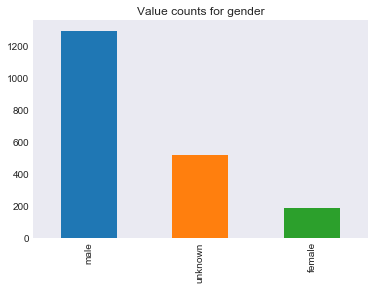

In [628]:
# Inspect distribution of genders over the tweets
pd.value_counts(dogs['gender']).plot.bar()
plt.title("Value counts for gender")
print(dogs['gender'].value_counts())

In [629]:
males = dogs[dogs['gender'] == 'male']
#Check for equal variance
print(np.var(males['rating_numerator']))
females = dogs[dogs['gender'] == 'female']
print(np.var(females['rating_numerator']))
stats.ttest_ind(males['rating_numerator'], females['rating_numerator'], equal_var=False)

2596.730158043455
5.649072542533082


Ttest_indResult(statistic=1.025957524736599, pvalue=0.3050986383979168)

Although the ratings usually are not very serious, we can still check if this difference in means is significant.  Running a t-test shows that the mean rating numerator for male dogs is not significantly different from the mean rating numerator for female dogs, meaning that there is probably no real difference in rating between male and female dogs. 

### 2. Which dog breed receives the highest ratings?

In [630]:
# Sort dog breeds by rating numerator
dogs.groupby(['dog_breed']).mean().sort_values(by = 'rating_numerator', ascending = False)

,tweet_id,rating_numerator,rating_denominator
dog_breed,,,
clumber,7.780270e+17,27.000000,10.0
soft-coated_wheaten_terrier,6.891948e+17,25.454545,10.0
west_highland_white_terrier,7.286353e+17,16.076923,10.0
great_pyrenees,7.410012e+17,14.928571,10.0
borzoi,7.177990e+17,14.444444,10.0
unknown,7.220930e+17,14.324952,10.0
labrador_retriever,7.479198e+17,13.905263,10.0
siberian_husky,7.476017e+17,13.250000,10.0
golden_retriever,7.570117e+17,13.208633,10.0


We can see that both clumbers and soft coated wheaten terriers receive very high mean ratings. It is possible however that these ratings come from only a very small number of tweets. To make this analysis a bit more meaningful, only dog breeds that received more than 25 ratings are included. 

In [631]:
# View dog breeds that occurred in the tweet pictures most frequently
dogs['dog_breed'].value_counts()

unknown                       517
golden_retriever              139
labrador_retriever             95
pembroke                       88
chihuahua                      79
pug                            54
chow                           41
samoyed                        40
pomeranian                     38
toy_poodle                     38
malamute                       29
cocker_spaniel                 27
french_bulldog                 26
chesapeake_bay_retriever       23
miniature_pinscher             22
siberian_husky                 20
german_shepherd                20
staffordshire_bullterrier      19
maltese_dog                    18
eskimo_dog                     18
shetland_sheepdog              18
cardigan                       17
shih-tzu                       17
rottweiler                     17
beagle                         17
italian_greyhound              16
kuvasz                         16
lakeland_terrier               16
great_pyrenees                 14
basset        

In [632]:
# Calculate mean rating_numerator for each dog breed that occurs 25 times or more
dogs[dogs['dog_breed'] == 'french_bulldog'].mean()

tweet_id              7.840937e+17
rating_numerator      1.126923e+01
rating_denominator    1.000000e+01
dtype: float64

Text(0.5,1,'Mean rating numerator per dog breed')

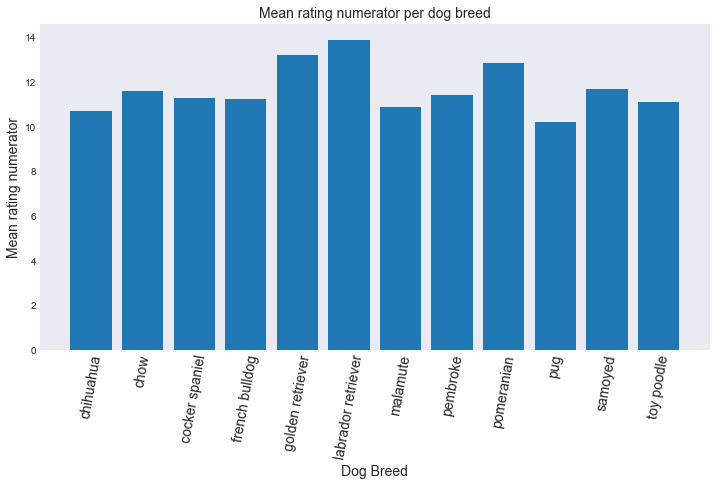

In [633]:
# Create bar chart for skills that show the highest correlation with overall rating
breed = ['chihuahua', 'chow', 'cocker spaniel', 'french bulldog', 'golden retriever','labrador retriever', 'malamute',
         'pembroke','pomeranian', 'pug',  'samoyed', 'toy poodle']
mean_rating =  [10.71, 11.61, 11.30, 11.27, 13.21, 13.91, 10.90, 11.44, 12.87, 10.24, 11.70, 11.11]
y_pos = np.arange(len(breed))

fig, ax = plt.subplots(figsize=(12,6))
plt.bar(y_pos, mean_rating)
plt.xticks(y_pos, breed, rotation=80, fontsize=14)
plt.xlabel('Dog Breed', fontsize=14)
plt.ylabel('Mean rating numerator', fontsize=14)
plt.title('Mean rating numerator per dog breed', fontsize=14)

The two highest rated dog breeds that occurred 25 times or more in the tweets, Labrador Retriever and Golden Retriever, are both in the top 3 of most popular dog breeds according to the [American Kennel Club](ttps://www.akc.org/expert-advice/news/most-popular-dog-breeds-full-ranking-list/). The lowest mean rating was for pugs, a breed that indeed may not meet the conventional dog beauty standards. 

### 3. Did the average ratings change over time?

In [634]:
# Merge the dogs and tweets dataframes to have timestamp and rating information in one dataframe
timestamp_analysis = pd.merge(dogs, tweets, on='tweet_id')
# Drop row with extreme outlier for rating_numerator (actually refers to a year and not to a rating)
timestamp_analysis.drop(timestamp_analysis[timestamp_analysis.rating_numerator > 1775].index, inplace=True)

In [635]:
# Drop columns that are not necessary for analysis and visualization
columns3 = ['tweet_id', 'text_x', 'dog_name', 'stage', 'dog_breed', 'rating_denominator', 'gender', 'text_y', 
            'retweet_count', 'favorites_count', 'source', 'expanded_urls']
timestamp_analysis.drop(columns3, inplace=True, axis=1)

In [636]:
# Store this new dataframe in order to use in other notebooks
timestamp_analysis.to_csv('timestamp_analysis.csv', encoding='utf-8', index=False)

In [637]:
# Calculate mean rating per week, sample code found at
# https://stackoverflow.com/questions/37842260/pandas-dataframe-resample-per-day-without-date-time-index?rq=1
ts_mean_by_week = timestamp_analysis.reset_index().set_index('timestamp').resample('W').mean()

Text(0.5,1,'Average WeRateDogs ratings per week')

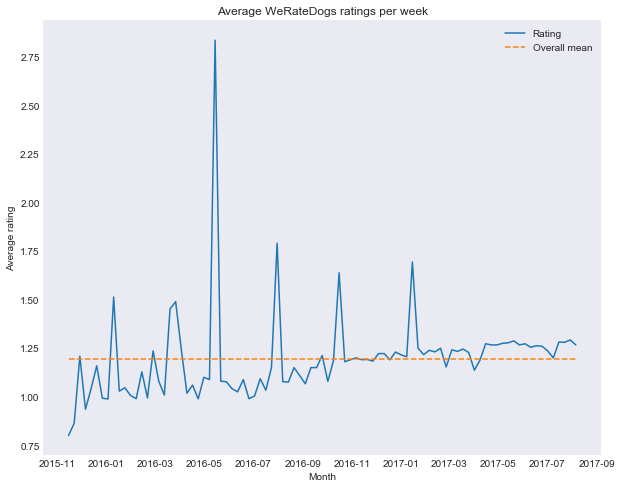

In [638]:
x = ts_mean_by_week.index
y = ts_mean_by_week['rating_numerator']/10
y_overall_mean = [np.mean(y)]*len(x)

fig, ax = plt.subplots(figsize=(10,8))
# Plot the averages per month
ax.plot(x,y, label = 'Rating')
# Plot the average line
ax.plot(x,y_overall_mean, label='Overall mean', linestyle='--')
plt.legend = ax.legend(loc='upper right')
plt.xlabel('Month')
plt.ylabel('Average rating')
plt.title('Average WeRateDogs ratings per week')

There are some spikes in the trendline when ratings were given for multiple dogs. Again: the ratings are not very serious so this is no "hard" analysis but when we compare the trend line to the overall mean, there is an upward trend visible: the mean rating did increase over time. This might be due for the precise reason that the ratings are more playful than serious: as Twitter users see that more people are giving higher ratings, they follow this trend. 

### Extra: the most frequently used words in the tweet texts

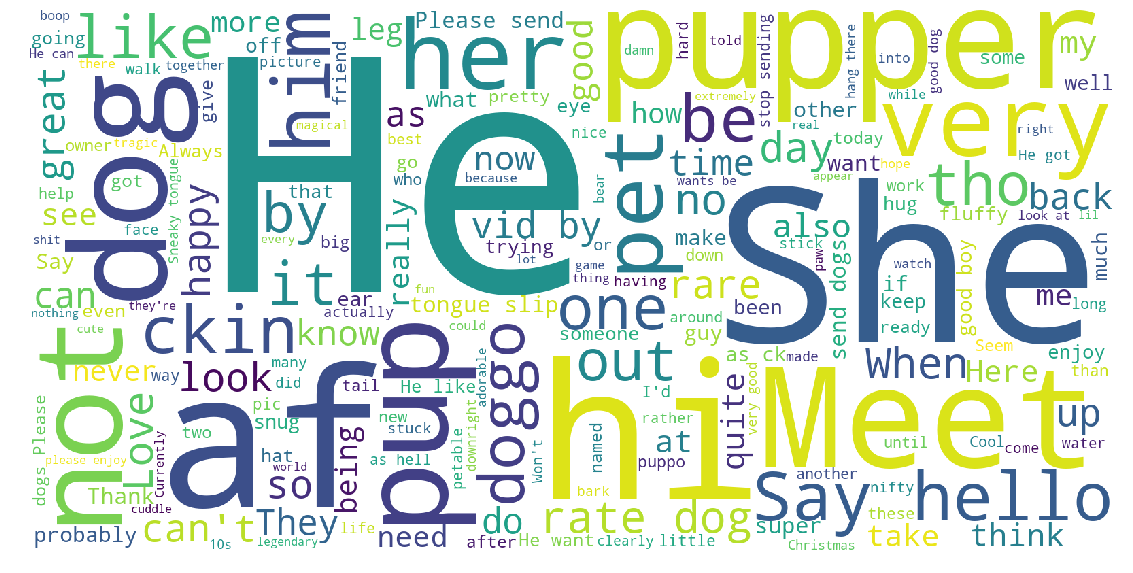

In [666]:
ignore_words = {'https', 'co', 'https', 'and', 'the', 'would', 'of', 'for', 'is', 'this', 'that', 'these', 'with', 'to',
               'but', 'both', 'them', 'about', 'an', 'a', 'still', 'amp', 'it', 'on', 'in', 'all', 'you', 'here',
                'have', 'get', 'from', 'are', 'was', 'will', 'only', 'we', 'has', 'just', 'too', "I'm", "doesn't",
               "don't", "you're", "won't" 'your'}
wordcloud = WordCloud(background_color="white", stopwords = ignore_words, width=1600, height=800).generate(' '.join(tweets['text']))

# Generate plot
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()


To conclude, I generated a word cloud of the words most frequently used in the tweet texts. Please note that the stopwords are left out quite arbitrarily. Again: this is not an in-depth analysis but a nice way to get a feeling for the vocabulary of the WeRateDogs tweets.

The most common words refer to the dog's gender, like "She", "he, "her" and "him". Looking at the font size of the words, tweets about pups/puppers are more common than about older dogs (which would make sense as puppies are very photogenic). Also, the common way to introduce dogs is clearly visible in the word cloud: "Meet [dog name]" and "Say hi/hello to [dog name]" are used often. The dog owners apparently also talk about body parts of their dogs, in the word cloud "leg", "tail", "paw" and "ear" can be found. 

And finally, we see words like "af", an internet slang acronym used often on social media. It stands for "as f#ck". The same is true for "ckin" which is used in the tweets as "h#ckin". This word comes, according to [Esquire](https://www.esquire.com/lifestyle/a54940/we-rate-dogs-matt-nelson-interview/) from ""oh h#ck," a silly censoring of an already-family-friendly word that strikes so many people as so funny that Nelson now sells hundreds of hats, mugs, and shirts with the phrase every month." H#cking, doggo, pupper, boop... all words from the DoggoLingo internet language to which WeRateDogs made a great contribution. 